# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy
import os
import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier

from DrTorch.metrics import F1_Score_Multi_Labels
from models.bertFull import BertFull


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi


Fri Feb 23 08:39:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P8               3W /  80W |     53MiB /  8188MiB |     31%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [4]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = "local-bert"

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [5]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Taking a look to same utterance example

In [6]:
display_utterance(dataframe=df, utterance_id='utterance_6')
display_utterance(dataframe=df, utterance_id='utterance_456')
display_utterance(dataframe=df, utterance_id='utterance_2005')


Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Removing NaN Values

In [7]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Analyzing the dataset

In [8]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in an utterance: {speakers['min_speakers']}")
print(f"Maximum number of speakers in an utterance: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in an utterance: {utterances['length_min']}")
print(f"Maximum number of sentences in an utterance: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in an utterance: 1
Maximum number of speakers in an utterance: 8

Minimum number of sentences in an utterance: 2
Maximum number of sentences in an utterance: 24


In [9]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


In [10]:
def concat_with_sep(string_list):
    return " [SEP] ".join(string_list)

df['processed_utterances'] = df['utterances'].apply(concat_with_sep)
df



,speakers,emotions,utterances,triggers,processed_utterances
episode,,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]",also I was the point person on my company's tr...
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",also I was the point person on my company's tr...
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",also I was the point person on my company's tr...
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",also I was the point person on my company's tr...
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]",But then who? The waitress I went out with las...
...,...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...


In [11]:
train_df, val_df, test_df = split_dataset(df)

display(train_df.head())
display(val_df.head())
display(test_df.head())


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_594,"[Chandler, Joey, Chandler, Joey, Chandler, Joe...","[neutral, joy, neutral, surprise, neutral, joy...","[Well, I just thought it'd make me feel good t...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Well, I just thought it'd make me feel good to..."
utterance_3813,"[Chandler, Joey, Chandler]","[fear, neutral, sadness]","[Yes that was mine., Cause I figured you'd hoo...","[0.0, 1.0, 1.0]",Yes that was mine. [SEP] Cause I figured you'd...
utterance_440,"[Ross, Chandler, Ross, Chandler, Ross, Joey, R...","[joy, surprise, neutral, disgust, sadness, joy...",[I know I miss you too. I can't wait to see yo...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",I know I miss you too. I can't wait to see you...
utterance_3882,"[Monica, Chandler, Ross, Chandler, Ross]","[surprise, neutral, joy, neutral, neutral]",[It's beautiful! It's like the first bathroom ...,"[0.0, 0.0, 0.0, 1.0, 0.0]",It's beautiful! It's like the first bathroom f...
utterance_2321,"[Chandler, Phoebe, All, All]","[neutral, neutral, disgust, anger]","[Well, maybe it's a contest, y'know? Like, col...","[0.0, 0.0, 0.0, 0.0]","Well, maybe it's a contest, y'know? Like, coll..."


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_2754,"[Ross, Rachel, Ross, Rachel, Ross, Rachel, Pho...","[joy, neutral, neutral, neutral, neutral, neut...","[Hey!, Hey, so did everything go all right wit...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Hey! [SEP] Hey, so did everything go all right..."
utterance_340,"[Rachel, Joanna, Rachel, Joanna, Rachel, Joann...","[neutral, neutral, fear, neutral, disgust, fea...","[My drinking?, Oh, I must've said that after y...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","My drinking? [SEP] Oh, I must've said that aft..."
utterance_2621,"[Monica, Rachel, Monica, Monica, Monica, Phoeb...","[joy, surprise, surprise, joy, neutral, sadnes...","[Now, this is last minute so I want to apologi...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","Now, this is last minute so I want to apologiz..."
utterance_1277,"[Ross, Chandler, Ross, Chandler, Ross, Chandle...","[neutral, surprise, neutral, surprise, joy, jo...","[Hi., Hey. Soaps? Shampoos? Are you really ta...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Hi. [SEP] Hey. Soaps? Shampoos? Are you reall...
utterance_60,"[Ross, Charlie, Ross, Charlie, Ross]","[anger, neutral, neutral, sadness, surprise]","[Get Out!, Ross, can I talk to you for a minut...","[0.0, 0.0, 0.0, 1.0, 0.0]","Get Out! [SEP] Ross, can I talk to you for a m..."


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_2447,"[Monica, Rachel, Phoebe, Rachel, Monica, Rache...","[neutral, joy, neutral, joy, joy, joy, neutral...","[Okay, the reason why I asked you guys out to ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","Okay, the reason why I asked you guys out to b..."
utterance_3303,"[Joey, Ross, Chandler, Chandler, Chandler, Ross]","[surprise, surprise, anger, anger, neutral, fear]","[Mark's a genius!, Why?! How?! How is he a gen...","[1.0, 0.0, 0.0, 1.0, 1.0, 0.0]",Mark's a genius! [SEP] Why?! How?! How is he a...
utterance_2530,"[Paul, Paul, Rachel, Paul, Paul, Paul, Paul, R...","[neutral, neutral, neutral, neutral, anger, sa...","[Okay., When I was six years old., Hm-mm, I wa...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]",Okay. [SEP] When I was six years old. [SEP] Hm...
utterance_3743,"[Phoebe, Rachel, Terry, Rachel, Terry, Terry, ...","[joy, neutral, neutral, neutral, neutral, neut...","[Hey Rach, wanna hear the new song I'm thinkin...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","Hey Rach, wanna hear the new song I'm thinkin'..."
utterance_87,"[Monica, Ross, Monica, Phoebe, Ross, Monica, P...","[surprise, neutral, joy, surprise, neutral, su...","[How does she do that?, I cannot sleep in a pu...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",How does she do that? [SEP] I cannot sleep in ...


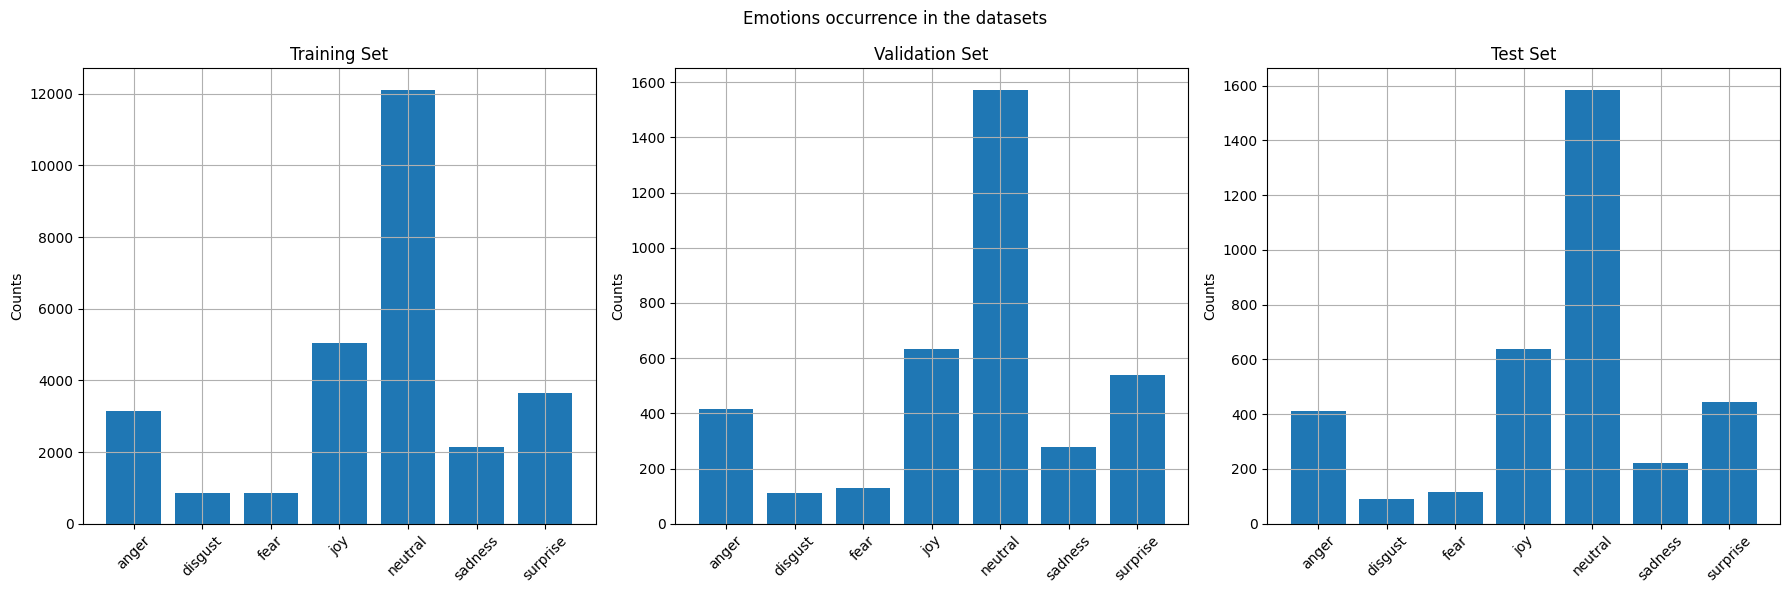

In [12]:
plot_emotion_distribution(train_df, val_df, test_df)


## Random Classifier

In [13]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
"""display_utterance(dataframe=new_test_df, utterance_id=0)  """


'display_utterance(dataframe=new_test_df, utterance_id=0)  '

## Majority Classifier

In [14]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
"""display_utterance(dataframe=new_test_df, utterance_id=0)"""


'display_utterance(dataframe=new_test_df, utterance_id=0)'

## Bert Models

#### Defining some maps

In [15]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
EMOTIONS_TO_INT = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
INT_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}


In [16]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


In [66]:
from typing import Dict
from DrTorch.utilities import DataLoaderFromPipelineStrategy
 
def construct_input(data):
    dialog, speakers = data['processed_utterances'], data['speakers']
    tokenizer = BertTokenizer.from_pretrained("local-bert")

    output =  tokenizer.batch_encode_plus(dialog,
                                    return_tensors="pt",
                                    padding=True, 
                                    return_token_type_ids=True)

    return output
 
dataLoaderBuilder = DataLoaderFromPipelineStrategy()
dataloader = dataLoaderBuilder.create(train_df[["processed_utterances", "speakers"]], 
                                      train_df[["emotions", "triggers"]], 
                                      shuffle=True,
                                      data_preprocess_f=construct_input, 
                                      batch_size=12,
                                      device=device)


for data, label in dataloader:
    print(data)
    


{'input_ids': tensor([[ 101, 1012, 1012,  ...,    0,    0,    0],
        [ 101, 7632, 7910,  ...,    0,    0,    0],
        [ 101, 2033, 2205,  ...,    0,    0,    0],
        ...,
        [ 101, 2092, 1010,  ...,    0,    0,    0],
        [ 101, 7632, 1012,  ...,    0,    0,    0],
        [ 101, 2079, 2017,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
{'input_ids': tensor([[ 101, 1045, 1005,  ...,    0,    0,    0],
        [ 101, 8016, 2033,  ...,    0,    0,    0],
        [ 101, 4931, 9558,  ...,    0,    0,    0],
        ...,
  

In [18]:
dialogs = [
    [
    "also I was the point person on my company's transition from the KL-5 to GR-6 system.",
    "You must've had your hands full.",
    "That I did. That I did.",
    "So let's talk a little bit about your duties.",
    "My duties? All right."
    ],
    ["cacca", "caccona"]
]

tokens = []
for dialog in dialogs:
    tokens.append(construct_input(dialog))

tokens

TypeError: list indices must be integers or slices, not str

In [80]:
import pandas as pd

# Creiamo un DataFrame di esempio
data = {'colonna_lista': [["stringa1", "stringa2", "stringa3"], ["stringa4", "stringa5"], ["stringa6"]]}
df = pd.DataFrame(data)

# Definiamo una funzione per concatenare le stringhe e inserire [SEP] tra di esse
def concat_with_sep(string_list):
    return " [SEP] ".join(string_list)

# Applichiamo la funzione alla colonna del DataFrame e creiamo una nuova colonna
df['colonna_concatenata'] = df['colonna_lista'].apply(concat_with_sep)

# Stampiamo il DataFrame per vedere i risultati
print(df)




                    colonna_lista                     colonna_concatenata
0  [stringa1, stringa2, stringa3]  stringa1 [SEP] stringa2 [SEP] stringa3
1            [stringa4, stringa5]                 stringa4 [SEP] stringa5
2                      [stringa6]                                stringa6


In [42]:
def generate_data_sample(data_dict, idx):
    sample = {}
    for key, value in data_dict.items():
        if isinstance(value, dict):
            sample[key] = generate_data_sample(value, idx)
        else:
            sample[key] = value[idx] if isinstance(value, torch.Tensor) and idx < value.shape[0] else None
    return sample

# Dizionario di esempio
data_dict = {
    'input_ids': {
        'sub_key1': {'prova':{'tensor': torch.tensor([1, 2, 3])}},
        'sub_key2': {'sub_sub_key': {'tensor': torch.tensor([4, 5, 6])}}
    },
    'token_type_ids': torch.tensor([7, 8]),
    'attention_mask': [
        {'tensor': torch.tensor([9, 10, 11])},
        {'tensor': torch.tensor([12, 13, 14])}
    ]
}

# Esempio di utilizzo della funzione con idx = 0
data_sample = generate_data_sample(data_dict, 0)
print(data_sample)

{'input_ids': {'sub_key1': {'prova': {'tensor': tensor(1)}}, 'sub_key2': {'sub_sub_key': {'tensor': tensor(4)}}}, 'token_type_ids': tensor(7), 'attention_mask': None}


In [51]:
x = dict()
print(isinstance(x,Dict))

True
